In [1]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:55<00:00, 20.9MB/s]
100% 1.06G/1.06G [00:55<00:00, 20.4MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
!pip install torchmetrics
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 46.3 MB/s eta 0:00:00


In [5]:
train_transforms=transforms.Compose([
    transforms.Resize(128),transforms.RandomResizedCrop(128),
                                     transforms.RandomHorizontalFlip(),
      transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                     transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )])
val_transforms=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(128),transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
train_dataset=datasets.ImageFolder('/content/train',transform=train_transforms)
val_dataset=datasets.ImageFolder('/content/test',transform=val_transforms)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)

In [7]:
class CNNModel(nn.Module):
  def __init__(self,pretrained=True,num_unfreeze_layers=0):
    super(CNNModel, self).__init__()
    if pretrained:
      self.model=models.resnet18(weights='ResNet18_Weights.DEFAULT')
      self.model.requires_grad_(False)
      if num_unfreeze_layers>0:
        num_layers=0
        for name, module in self.model.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        num_layers+=1
        start_unfreezing_counter,counter=num_layers-num_unfreeze_layers,0
        for name, module in self.model.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        counter+=1
                    if counter >= start_unfreezing_counter:
                        module.requires_grad_(True)
      self.model.fc = nn.Linear(512, 500)  # Correctly replace the 1000 output to match your custom FC

        # Add a new fully connected layer for your custom classification
      self.fc = nn.Sequential(
            nn.Linear(500, 500),  # Now matches the modified resnet output
            nn.ReLU(),
            nn.Linear(500, 2)  # Assuming 2 output classes
        )

  def forward(self, x):
    with torch.cuda.amp.autocast():
        # Pass input through ResNet backbone
        out = self.model(x)

        # Now, `out` has shape [batch_size, 500], already flattened due to the new FC layer in resnet
        out = self.fc(out)  # Pass through the new classification head

    return out


In [8]:
# This variable will be used to save the per-epoch validation accuracy
deep_finetuning_val_acc = list()
# This variable will be used to save the per-epoch training loss
deep_finetuning_train_loss = list()

# Define the model
model = CNNModel(pretrained=True, num_unfreeze_layers=31)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



In [10]:
import torch.cuda.amp as amp

def train_model(model, criterion, optimizer, train_loader, val_loader, scheduler=None, epochs=20):
    scaler = amp.GradScaler()  # Mixed precision scaler
    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with amp.autocast():  # Enable mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()  # Scale gradients
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)} - Loss: {running_loss/10:.4f}")
                running_loss = 0.0

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)

        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_acc_list.append(val_acc)
        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}")

        if scheduler is not None:
            scheduler.step()

    return train_acc_list, val_acc_list


<ipython-input-10-7d7d65bae62a>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # Mixed precision scaler
<ipython-input-10-7d7d65bae62a>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():  # Enable mixed precision
<ipython-input-7-dce7cf042faa>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10, Batch 0/625 - Loss: 0.0674
Epoch 1/10, Batch 10/625 - Loss: 0.6618
Epoch 1/10, Batch 20/625 - Loss: 0.5901
Epoch 1/10, Batch 30/625 - Loss: 0.5374
Epoch 1/10, Batch 40/625 - Loss: 0.5351
Epoch 1/10, Batch 50/625 - Loss: 0.5017
Epoch 1/10, Batch 60/625 - Loss: 0.5276
Epoch 1/10, Batch 70/625 - Loss: 0.5279
Epoch 1/10, Batch 80/625 - Loss: 0.4255
Epoch 1/10, Batch 90/625 - Loss: 0.4887
Epoch 1/10, Batch 100/625 - Loss: 0.4994
Epoch 1/10, Batch 110/625 - Loss: 0.4775
Epoch 1/10, Batch 120/625 - Loss: 0.5202
Epoch 1/10, Batch 130/625 - Loss: 0.5353
Epoch 1/10, Batch 140/625 - Loss: 0.4583
Epoch 1/10, Batch 150/625 - Loss: 0.4131
Epoch 1/10, Batch 160/625 - Loss: 0.4983
Epoch 1/10, Batch 170/625 - Loss: 0.4705
Epoch 1/10, Batch 180/625 - Loss: 0.4261
Epoch 1/10, Batch 190/625 - Loss: 0.4181
Epoch 1/10, Batch 200/625 - Loss: 0.4679
Epoch 1/10, Batch 210/625 - Loss: 0.5137
Epoch 1/10, Batch 220/625 - Loss: 0.4035
Epoch 1/10, Batch 230/625 - Loss: 0.4581
Epoch 1/10, Batch 240/625 -

<ipython-input-10-7d7d65bae62a>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [1/10], Train Acc: 78.74%, Val Acc: 90.12%, Val Loss: 0.2426
Epoch 2/10, Batch 0/625 - Loss: 0.0275
Epoch 2/10, Batch 10/625 - Loss: 0.3353
Epoch 2/10, Batch 20/625 - Loss: 0.4039
Epoch 2/10, Batch 30/625 - Loss: 0.3169
Epoch 2/10, Batch 40/625 - Loss: 0.3747
Epoch 2/10, Batch 50/625 - Loss: 0.3508
Epoch 2/10, Batch 60/625 - Loss: 0.3310
Epoch 2/10, Batch 70/625 - Loss: 0.4492
Epoch 2/10, Batch 80/625 - Loss: 0.3974
Epoch 2/10, Batch 90/625 - Loss: 0.3200
Epoch 2/10, Batch 100/625 - Loss: 0.4189
Epoch 2/10, Batch 110/625 - Loss: 0.3951
Epoch 2/10, Batch 120/625 - Loss: 0.4997
Epoch 2/10, Batch 130/625 - Loss: 0.3626
Epoch 2/10, Batch 140/625 - Loss: 0.4011
Epoch 2/10, Batch 150/625 - Loss: 0.3429
Epoch 2/10, Batch 160/625 - Loss: 0.3868
Epoch 2/10, Batch 170/625 - Loss: 0.3954
Epoch 2/10, Batch 180/625 - Loss: 0.3776
Epoch 2/10, Batch 190/625 - Loss: 0.3821
Epoch 2/10, Batch 200/625 - Loss: 0.3473
Epoch 2/10, Batch 210/625 - Loss: 0.3942
Epoch 2/10, Batch 220/625 - Loss: 0.3959
E

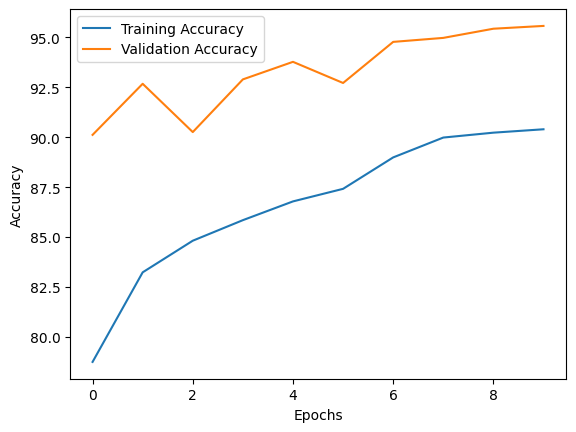

In [11]:
train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader,scheduler,epochs=10)

# Plot training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
from PIL import Image

In [18]:
# Define the validation transformations (same as used during validation)
val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path ='/content/dogtesterdogvscat.jfifp'   # Path to your image
image = Image.open('/content/dogtesterdogvscat.jfif')
image = val_transforms(image)
image = image.unsqueeze(0)  # Add batch dimension

# Send the image to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)

# Load your trained model and move it to the device
model = CNNModel(pretrained=True, num_unfreeze_layers=31)  # Initialize model
model = model.to(device)
model.eval()  # Set model to evaluation mode

# Inference
with torch.no_grad():
    with amp.autocast():  # Mixed precision for faster inference
        output = model(image)

# Apply softmax to get probabilities
probabilities = torch.softmax(output, dim=1)

# Get the predicted class
predicted_class = torch.argmax(probabilities, dim=1)

print(f"Predicted Class: {predicted_class.item()}")
print(f"Probabilities: {probabilities.cpu().numpy()[0]}")

Predicted Class: 1
Probabilities: [0.479 0.521]


<ipython-input-18-3d7282bd08f6>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():  # Mixed precision for faster inference
<ipython-input-7-dce7cf042faa>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
